<a href="https://colab.research.google.com/github/annesofiedahl/M1-Exam/blob/main/SDS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

M1: Applied Data Science and Machine Learning - Group; Fri-62786-17 - Authors; Anne Sofie Stæhr Dahl & Nicklas Stiborg Møller



#**1. Introduction**

## 1.1 Problem Statement

**Which factors are affecting life expectancy across countries?**

  - Is there any correlation between diseases and countries' wealth & status?

  - Can countries be grouped across these parameters? 


## 1.2 Data Acquisition 

"The Global Health Observatory (GHO) data repository under World Health Organization (WHO) keeps track of the health status as well as many other related factors for all countries The datasets are made available to public for the purpose of health data analysis. The dataset related to life expectancy, health factors for 193 countries has been collected from the same WHO data repository website and its corresponding economic data was collected from United Nation website. Among all categories of health-related factors only those critical factors were chosen which are more representative. It has been observed that in the past 15 years , there has been a huge development in health sector resulting in improvement of human mortality rates especially in the developing nations in comparison to the past 30 years. Therefore, in this project we have considered data from year 2000-2015 for 193 countries for further analysis. The individual data files have been merged together into a single dataset. On initial visual inspection of the data showed some missing values. As the datasets were from WHO, we found no evident errors. Missing data was handled in R software by using Missmap command. The result indicated that most of the missing data was for population, Hepatitis B and GDP. The missing data were from less known countries like Vanuatu, Tonga, Togo,Cabo Verde etc. Finding all data for these countries was difficult and hence, it was decided that we exclude these countries from the final model dataset. The final merged file(final dataset) consists of 22 Columns and 2938 rows which meant 20 predicting variables. All predicting variables was then divided into several broad categories:​Immunization related factors, Mortality factors, Economical factors and Social factors."

*Source: https://www.kaggle.com/tsatir/model-preparation/data*

# **2. Data Preparation** 

During this phase of the project, the focus will primarily lie on data preparation, including cleaning the dataset of obsolete data, to prepare for further analysis. This entails renaming some of the column names, due to spelling errors and unnecessary whitespace. When examining the data, it became clear that some of the columns in the dataframe are missing data. There are generally three approaches that can be considered, to handle this issue, either filling in the values from other datasets, dropping the value, or using interpolation in an attempt to make a “qualified guess” using linear regression.

If all of the countries with missing values, had some populations registered, interpolate could most likely be a candidate for filling out the missing values, however, since it is using linear regression, the predictions would, in the best case, be flawed. This is due to some countries have extensive growth in population over a small duration of time, causing the interpolate unreliable.

There is also the option to merge columns into the dataset from other datasets. This requires both datasets to have a high degree of reliability since the recorded populations need to be as similar as possible (in both datasets), to avoid distortion. Some datasets could have a 10-20% higher population, due to other measures. This is required to achieve reliable clustering. This also requires that at least one column of each dataset are very close to or completely identical, to merge those properly. Such a merge can be achieved using joins, through the merge() and join() functions in Pandas.

Another method for handling the missing values is filling out the dataset with specific values, one of which could be using fillna() with a specific value from the dataframe (‘value=x’), or by using bfill/ffill, which copies either the over-or underlying values.

It has not been possible to find such a dataset, and since the interpolate() method has been deemed unreliable, the NaN values will be dropped from the dataset. Another reason for this is, that observations performed on the data set indicate that if one of the countries lacks data, it is often consistent for a big part of the data values or all of them. Due to this observation, the population values for such countries must be dropped, to avoid distortion in the dataset. Because of this, the most preferable function is dropna() from the Pandas library, which removed the rows containing missing values from the dataset.

In [604]:
!pip install umap-learn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
import umap.umap_ as umap
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [605]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [606]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [607]:
#https://drive.google.com/file/d/1qVi6v1IwGQS4MJ4NwiR8hcpJy3PiBGtl/view?usp=sharing
fileDownloaded = drive.CreateFile({'id':'1qVi6v1IwGQS4MJ4NwiR8hcpJy3PiBGtl'})

In [608]:
fileDownloaded.GetContentFile('life_expectancy_data.csv')

In [609]:
# read csv from drive
df = pd.read_csv('life_expectancydata.csv')
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [610]:
# Viewing the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [611]:
# Renaming columns
df.rename(columns = {"GDP": "gdp", "Polio": "polio", "Population": "population", "Schooling": "schooling", "Income composition of resources": "income_composition_of_resources", 
                    "Country":"country", "Year":"year", "Status": "status"," BMI ":"bmi","Life expectancy ":"life_expectancy","Adult Mortality":"adult_mortality",
                   "infant deaths":"infant_deaths","percentage expenditure":"percentage_expenditure","Hepatitis B":"hepatitis_b",
                  "Measles ":"measles", "under-five deaths ":"under_five_deaths","Diphtheria ":"diphtheria",
                  " HIV/AIDS":"hi_ai"," thinness  1-19 years":"thinness_10_to_19_years"," thinness 5-9 years":"thinness_5_to_9_years",
                   "Total expenditure":"total_expenditure", "Alcohol": "alcohol"},inplace=True)

In [612]:
# Checking for missing value in each column of the dataframe
df.isnull().sum()

country                              0
year                                 0
status                               0
life_expectancy                     10
adult_mortality                     10
infant_deaths                        0
alcohol                            194
percentage_expenditure               0
hepatitis_b                        553
measles                              0
bmi                                 34
under_five_deaths                    0
polio                               19
total_expenditure                  226
diphtheria                          19
hi_ai                                0
gdp                                448
population                         652
thinness_10_to_19_years             34
thinness_5_to_9_years               34
income_composition_of_resources    167
schooling                          163
dtype: int64

The dataset in question lacks values especially in the “HepatitiesB” column, which results in it being dropped. Dropping values has been performed on rows with missing values, resulting in the dataframe depicted below, containing 2094 values after being processed.

In [613]:
# Dropping the hepatitisB column
df = df.drop('hepatitis_b', axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   status                           2938 non-null   object 
 3   life_expectancy                  2928 non-null   float64
 4   adult_mortality                  2928 non-null   float64
 5   infant_deaths                    2938 non-null   int64  
 6   alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   measles                          2938 non-null   int64  
 9   bmi                              2904 non-null   float64
 10  under_five_deaths                2938 non-null   int64  
 11  polio                            2919 non-null   float64
 12  total_expenditure   

In [614]:
# dropping the remaining missing values
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2937
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2094 non-null   object 
 1   year                             2094 non-null   int64  
 2   status                           2094 non-null   object 
 3   life_expectancy                  2094 non-null   float64
 4   adult_mortality                  2094 non-null   float64
 5   infant_deaths                    2094 non-null   int64  
 6   alcohol                          2094 non-null   float64
 7   percentage_expenditure           2094 non-null   float64
 8   measles                          2094 non-null   int64  
 9   bmi                              2094 non-null   float64
 10  under_five_deaths                2094 non-null   int64  
 11  polio                            2094 non-null   float64
 12  total_expenditure   

After having filtered out missing values, it is also needed to remove outliers in the individual columns in the dataframe, which could also be another source of distortion.

This can be done by creating a dictionary containing all of the columns that are desired to be visualized in boxplots. The boxplots have been sketched below, showing the outliers in the columns as round dots. Below these boxplots, a comparison between three of the columns in the original boxplots and the winsorized versions, which removes outliers. This is done for all of the columns containing outliers. Afterward, these columns are added to the original dataframe, thus replacing the original columns. Lastly, during the data cleaning the type of the Status column will be changed to a numerical number, so that it can be used for purposes, expanded upon later on. The boxplots are plotted using the Matplotlib.pyplot library, hereof functions such as figure() and boxplot(). These also provide the visualization of the boxplots. Following this, the winsorize() function from the scipy library is used to remove the outliers.

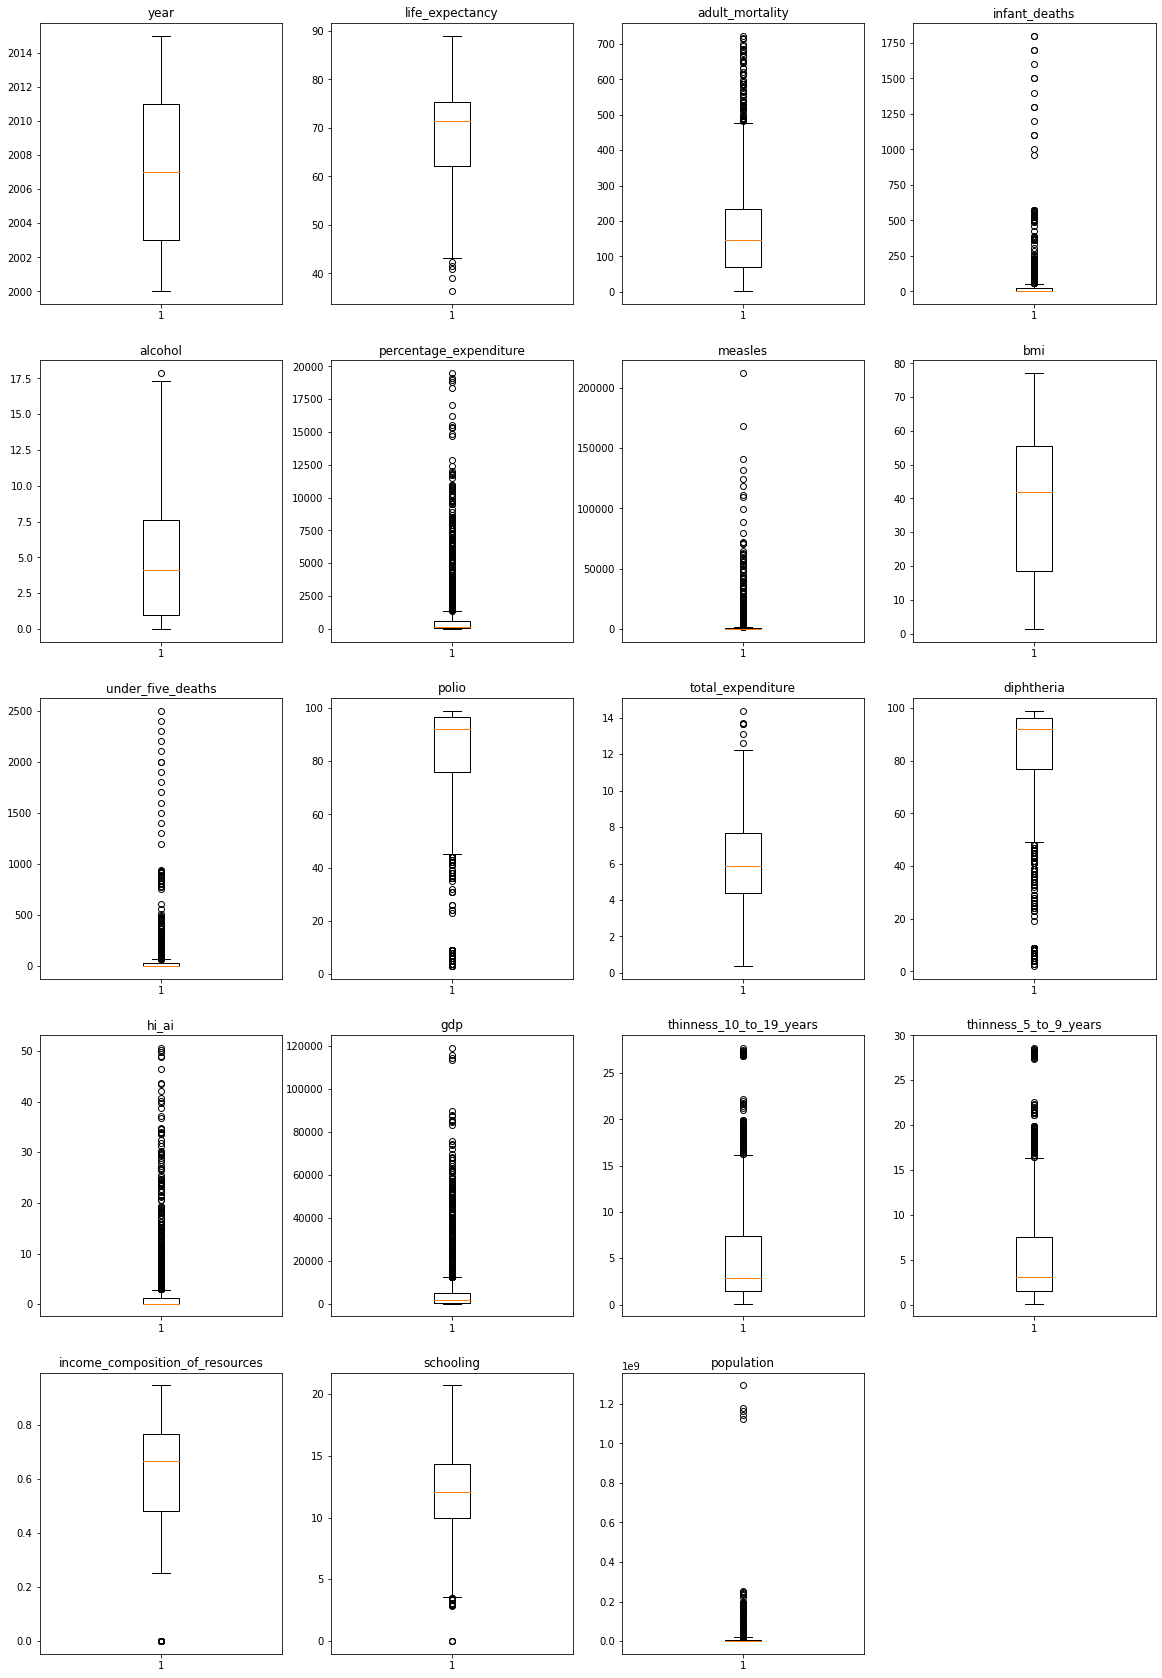

In [615]:
# creating a dictionary of the variables for boxplotting
dict = {'year' : 1, 'life_expectancy' : 2, 'adult_mortality' : 3,
       'infant_deaths' : 4, 'alcohol' : 5, 'percentage_expenditure' : 6,
       'measles' : 7, 'bmi' : 8, 'under_five_deaths' : 9, 'polio' : 10, 
       'total_expenditure' : 11, 'diphtheria' : 12, 'hi_ai' : 13, 'gdp' : 14, 'thinness_10_to_19_years' : 15,
       'thinness_5_to_9_years' : 16, 'income_composition_of_resources' : 17, 'schooling' : 18, 'population' : 19}

plt.figure(figsize=(20,30))

for variable,i in dict.items():
                     plt.subplot(5,4,i)
                     plt.boxplot(df[variable],whis=1.5)
                     plt.title(variable)
plt.show()

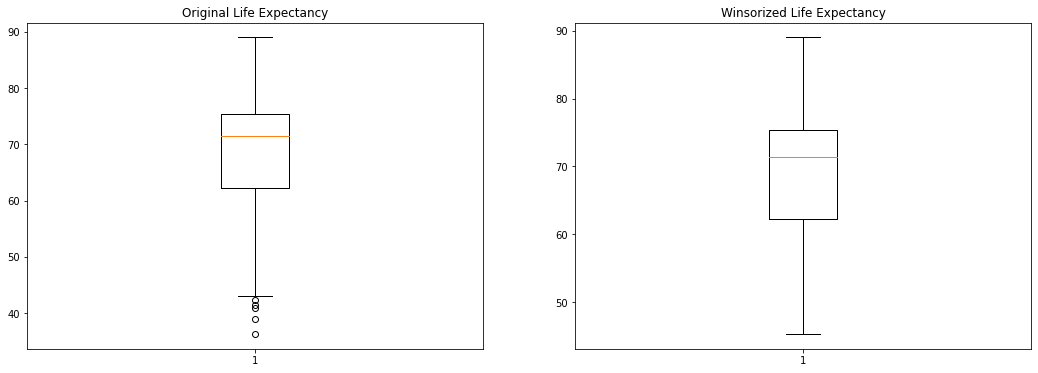

In [616]:
# visualizing variables 

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_life_expectancy = df['life_expectancy']
plt.boxplot(original_life_expectancy)
plt.title("Original Life Expectancy")

plt.subplot(1,2,2)
winsorized_life_expectancy = winsorize(df['life_expectancy'], (0.01,0))
plt.boxplot(winsorized_life_expectancy)
plt.title("Winsorized Life Expectancy")

plt.show()


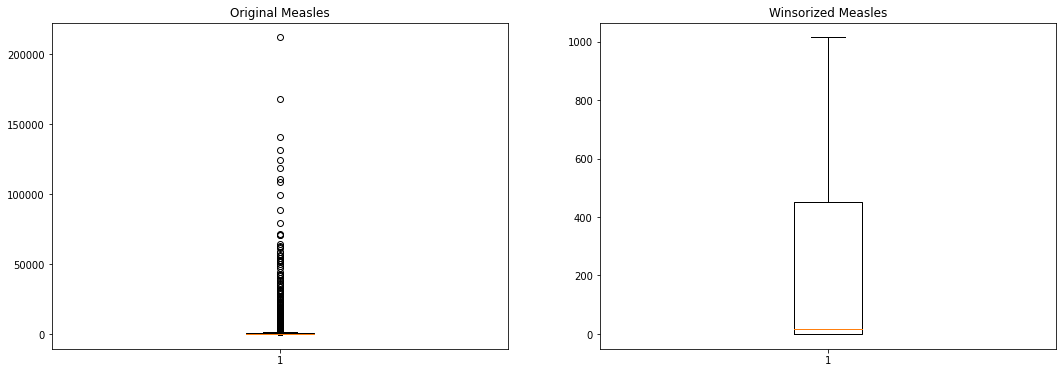

In [617]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_measles = df['measles']
plt.boxplot(original_measles)
plt.title("Original Measles")

plt.subplot(1,2,2)
winsorized_measles = winsorize(df['measles'], (0,0.19))
plt.boxplot(winsorized_measles)
plt.title("Winsorized Measles")

plt.show()

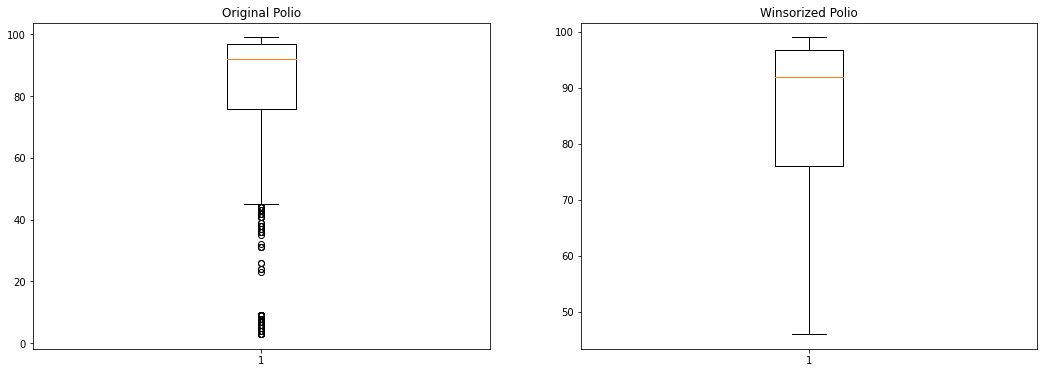

In [618]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_polio = df['polio']
plt.boxplot(original_polio)
plt.title("Original Polio")

plt.subplot(1,2,2)
winsorized_polio = winsorize(df['polio'], (0.09,0))
plt.boxplot(winsorized_polio)
plt.title("Winsorized Polio")

plt.show()

In [619]:
# filtering all relevant columns for outliers

winsorized_adult_mortality = winsorize(df['adult_mortality'], (0,0.03))
winsorized_polio = winsorize(df['polio'], (0.09,0))
winsorized_infant_deaths = winsorize(df['infant_deaths'], (0,0.10))
winsorized_alcohol = winsorize(df['alcohol'], (0,0.1))
winsorized_percentage_expenditure = winsorize(df['percentage_expenditure'], (0,0.12))
winsorized_measles = winsorize(df['measles'], (0,0.19))
winsorized_under_five_deaths = winsorize(df['under_five_deaths'], (0,0.12))
winsorized_total_expenditure = winsorize(df['total_expenditure'], (0,0.01))
winsorized_diphtheria = winsorize(df['diphtheria'], (0.10,0))
winsorized_hi_ai = winsorize(df['hi_ai'], (0,0.16))
winsorized_thinness_10_to_19_years = winsorize(df['thinness_10_to_19_years'], (0,0.04))
winsorized_thinness_5_to_9_years = winsorize(df['thinness_5_to_9_years'], (0,0.04))
winsorized_income_composition_of_resources = winsorize(df['income_composition_of_resources'], (0.05,0))
winsorized_schooling = winsorize(df['schooling'], (0.02,0.01))

In [620]:
# adding winsorized columns to the original dataframe, dropping original columns and renaming new ones

df['winsorized_life_expectancy'] = winsorized_life_expectancy
df['winsorized_polio'] = winsorized_polio
df['winsorized_adult_mortality'] = winsorized_adult_mortality
df['winsorized_infant_deaths'] = winsorized_infant_deaths
df['winsorized_alcohol'] = winsorized_alcohol
df['winsorized_percentage_expenditure'] = winsorized_percentage_expenditure
df['winsorized_measles'] = winsorized_measles
df['winsorized_polio'] = winsorized_polio
df['winsorized_under_five_deaths'] = winsorized_under_five_deaths
df['winsorized_total_expenditure'] = winsorized_total_expenditure
df['winsorized_diphtheria'] = winsorized_diphtheria
df['winsorized_hi_ai'] = winsorized_hi_ai
df['winsorized_thinness_10_to_19_years'] = winsorized_thinness_10_to_19_years
df['winsorized_thinness_5_to_9_years'] = winsorized_thinness_5_to_9_years
df['winsorized_income_composition_of_resources'] = winsorized_income_composition_of_resources
df['winsorized_schooling'] = winsorized_schooling

df = df.drop(columns = ['life_expectancy', 'polio', 'under_five_deaths', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'measles', 'total_expenditure', 'diphtheria', 'hi_ai', 'thinness_10_to_19_years', 'thinness_5_to_9_years', 'income_composition_of_resources', 'schooling'])
df = df.rename(columns = {"winsorized_life_expectancy": "life_expectancy", "winsorized_polio": "polio", "winsorized_under_five_deaths": "under_five_deaths", "winsorized_adult_mortality": "adult_mortality", "winsorized_infant_deaths": "infant_deaths", "winsorized_alcohol": "alcohol", "winsorized_percentage_expenditure": "percentage_expenditure", "winsorized_measles": "measles", "winsorized_total_expenditure": "total_expenditure", "winsorized_diphtheria": "diphtheria", "winsorized_hi_ai": "hi_ai", "winsorized_thinness_10_to_19_years": "thinness_10_to_19_years", "winsorized_thinness_5_to_9_years":"thinness_5_to_9_years", "winsorized_income_composition_of_resources": "income_composition_of_resources", "winsorized_schooling": "schooling"})

In [621]:
# Changing the status columns to binary to prepare for ML use
df.loc[:,'status'] = df.status.str.replace('Developing','0')
df.loc[:,'status'] = df.status.str.replace('Developed','1')
df['status'] = pd.to_numeric(df['status'])

# Checking datatypes - to ensure only numerical values

df.info()

# Dropping the country column in the new variable containing only numerical values
df_num = df.drop(columns='country')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2937
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2094 non-null   object 
 1   year                             2094 non-null   int64  
 2   status                           2094 non-null   int64  
 3   bmi                              2094 non-null   float64
 4   gdp                              2094 non-null   float64
 5   population                       2094 non-null   float64
 6   life_expectancy                  2094 non-null   float64
 7   polio                            2094 non-null   float64
 8   adult_mortality                  2094 non-null   float64
 9   infant_deaths                    2094 non-null   int64  
 10  alcohol                          2094 non-null   float64
 11  percentage_expenditure           2094 non-null   float64
 12  measles             

In [622]:
# Display the cleaned dataframe 

df.head()
df.describe()

,year,status,bmi,gdp,population,life_expectancy,polio,adult_mortality,infant_deaths,alcohol,percentage_expenditure,measles,under_five_deaths,total_expenditure,diphtheria,hi_ai,thinness_10_to_19_years,thinness_5_to_9_years,income_composition_of_resources,schooling
count,2094.000000,2094.000000,2094.000000,2094.000000,2.094000e+03,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000
mean,2007.018625,0.186246,37.182856,6737.616628,1.297307e+07,68.690544,83.973257,166.593601,14.578319,4.611318,414.016392,269.798949,20.236867,6.007727,84.226361,0.787249,4.728319,4.771824,0.632769,11.961366
std,4.314349,0.389398,19.744411,13817.626527,6.327112e+07,9.845865,16.812483,121.873606,20.389479,3.785171,562.233547,403.185709,28.831873,2.345372,16.485942,1.071810,4.132905,4.173099,0.178528,3.204245
min,2000.000000,0.000000,1.400000,1.681350,3.400000e+01,45.300000,46.000000,1.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.370000,47.000000,0.100000,0.100000,0.100000,0.292000,4.700000
25%,2003.000000,0.000000,18.500000,418.760067,1.914238e+05,62.200000,76.000000,71.000000,0.000000,1.000000,31.604560,0.000000,1.000000,4.400000,77.000000,0.100000,1.500000,1.500000,0.482250,10.000000
50%,2007.000000,0.000000,41.900000,1467.173451,1.351370e+06,71.400000,92.000000,146.000000,3.000000,4.140000,128.085100,17.500000,4.000000,5.890000,92.000000,0.100000,2.900000,3.100000,0.666000,12.100000
75%,2011.000000,0.000000,55.575000,5145.055820,7.280902e+06,75.400000,96.750000,235.000000,22.000000,7.580000,563.982589,453.000000,30.000000,7.677500,96.000000,1.200000,7.400000,7.475000,0.767000,14.300000
max,2015.000000,1.000000,77.100000,119172.741800,1.293859e+09,89.000000,99.000000,486.000000,60.000000,10.960000,1694.467075,1014.000000,82.000000,11.710000,99.000000,2.900000,15.400000,15.600000,0.945000,18.700000


#**3. Exploratory Data Analysis**

This part of the project will, using various methods and visualization, inspect the dataset in greater detail. The summary statistics concerning the dataset will be displayed, more specifically the mean, standard deviation, mininum and maximum values and the 25th, 50th and 75th percentile concerning each of the columns. In order to obtain a better understanding of the dataframe, it is relevant to examine the individual columns and the values stored inside of them. 

The dataframe consists of data concerning 141 countries in each of the years between 2000 and 2015. The BMI is ranging from 1.40 to 77.1 at value. The GDP is measured as GDP per capita in USD. The population column defines the number of people living in the country at that time. Life Expectancy is calculated as the average life expectancy in the specific year. The column Polio defines the immunization column among the 1-year olds in percent, and so does the Diphtheria column contains the tetanus toxoid and pertussis immunization coverage among the same age group. The Adult Mortality column defines the probability of dying between 15 and 60 years per 1000 population, whereas the Infant Deaths column defines the number of infant deaths per 1000 population. The Alcohol column contains the recorded per capita consumption (in litres) of pure alcohol. The Total Expenditure column measures the expenditure on health as a percentage of GDP per capita in percent. The HIV/AIDS (hi_ai) column contains the per 1000 live births HIV/AIDS among the 0-4 years. The two thinness columns defines the ages 5-9 years and 10-19 years and the prevalence of thinness among children in the age groups. The colums concerning the Income Composition of Resources is defined by the Human Development Index in terms of income compostion of resources - here an index ranging from 0 to 1. The last column, Schooling, defines the average number of years that the population had attended school.

The abovementioned variables are plotted below using the matplotlib.pyplot library once again, this time using the hist() function in order to create a histogram.

After displaying the summary statistics concerning the numerical values, using head(), the info regarding the categorical values is displayed. 


In [623]:
# In this column we are going to show some of the summary statistics concerning the cleaned dataset

df.describe()

,year,status,bmi,gdp,population,life_expectancy,polio,adult_mortality,infant_deaths,alcohol,percentage_expenditure,measles,under_five_deaths,total_expenditure,diphtheria,hi_ai,thinness_10_to_19_years,thinness_5_to_9_years,income_composition_of_resources,schooling
count,2094.000000,2094.000000,2094.000000,2094.000000,2.094000e+03,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000
mean,2007.018625,0.186246,37.182856,6737.616628,1.297307e+07,68.690544,83.973257,166.593601,14.578319,4.611318,414.016392,269.798949,20.236867,6.007727,84.226361,0.787249,4.728319,4.771824,0.632769,11.961366
std,4.314349,0.389398,19.744411,13817.626527,6.327112e+07,9.845865,16.812483,121.873606,20.389479,3.785171,562.233547,403.185709,28.831873,2.345372,16.485942,1.071810,4.132905,4.173099,0.178528,3.204245
min,2000.000000,0.000000,1.400000,1.681350,3.400000e+01,45.300000,46.000000,1.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.370000,47.000000,0.100000,0.100000,0.100000,0.292000,4.700000
25%,2003.000000,0.000000,18.500000,418.760067,1.914238e+05,62.200000,76.000000,71.000000,0.000000,1.000000,31.604560,0.000000,1.000000,4.400000,77.000000,0.100000,1.500000,1.500000,0.482250,10.000000
50%,2007.000000,0.000000,41.900000,1467.173451,1.351370e+06,71.400000,92.000000,146.000000,3.000000,4.140000,128.085100,17.500000,4.000000,5.890000,92.000000,0.100000,2.900000,3.100000,0.666000,12.100000
75%,2011.000000,0.000000,55.575000,5145.055820,7.280902e+06,75.400000,96.750000,235.000000,22.000000,7.580000,563.982589,453.000000,30.000000,7.677500,96.000000,1.200000,7.400000,7.475000,0.767000,14.300000
max,2015.000000,1.000000,77.100000,119172.741800,1.293859e+09,89.000000,99.000000,486.000000,60.000000,10.960000,1694.467075,1014.000000,82.000000,11.710000,99.000000,2.900000,15.400000,15.600000,0.945000,18.700000


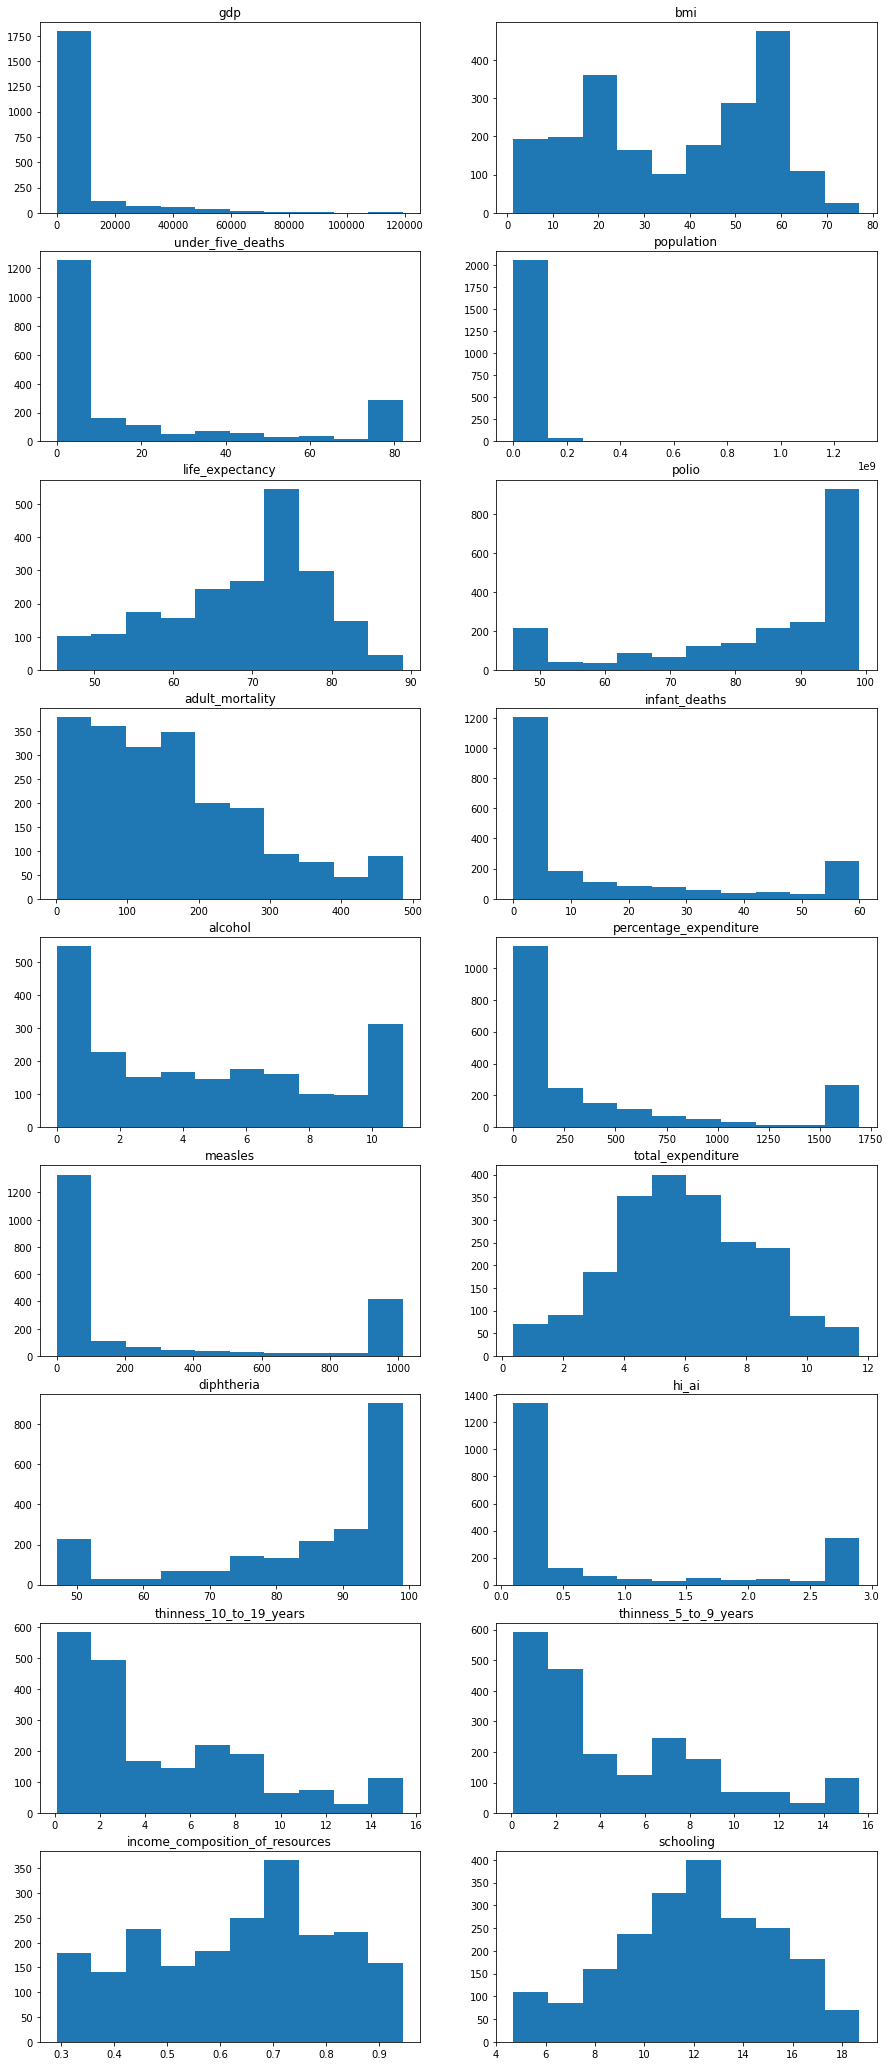

In [624]:
# visualizing the variables

visualizing_col = ['gdp', 'bmi', 'under_five_deaths', 'population', 'life_expectancy', 'polio', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'measles', 'total_expenditure', 'diphtheria', 'hi_ai', 'thinness_10_to_19_years', 'thinness_5_to_9_years', 'income_composition_of_resources', 'schooling']

plt.figure(figsize=(15,75))

for i in range(len(visualizing_col)):
    plt.subplot(18,2,i+1)
    plt.hist(df[visualizing_col[i]])
    plt.title(visualizing_col[i])
plt.show()


In [625]:
# inspecting the categorical columns 

df.describe(include=['O'])

,country
count,2094
unique,141
top,Afghanistan
freq,16


In the following part, some of the more interesting aspects of the dataset is plotted. First a bar chart is created, showing the average life expectancy in both developing and developed countries. This shows a huge difference, in a sense that people in developed countries tend to have a greater life expectancy. Following this a visualization of the evolution in the average life expectancy is plotted, based on 15 years of observations. This shows an approximate increase in life expectancy from 66 to 72 years. Lastly, the correlation matrix concerning the values in the dataframe, will be plotted.

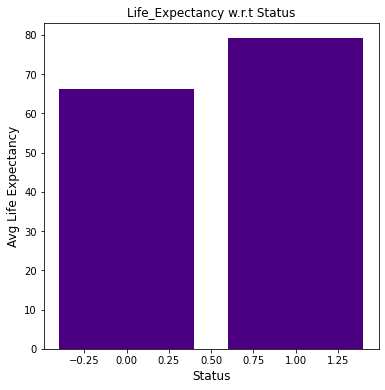

In [626]:
# life expectancy vs. status 

plt.figure(figsize=(6,6))
plt.bar(df.groupby('status')['status'].count().index,df.groupby('status')['life_expectancy'].mean(), color = 'indigo')
plt.xlabel("Status",fontsize=12)
plt.ylabel("Avg Life Expectancy",fontsize=12)
plt.title("Life_Expectancy w.r.t Status")
plt.show()

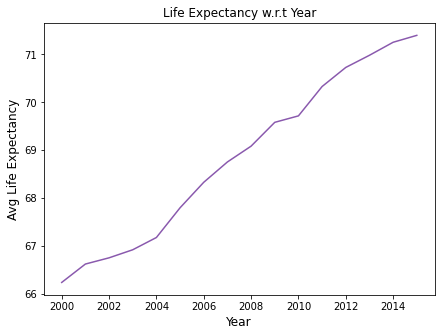

In [627]:
# yearly evolution of the average life expectancy

plt.figure(figsize=(7,5))
plt.plot(df.groupby('year')['year'].count().index,df.groupby('year')['life_expectancy'].mean(),color='indigo',alpha=0.65)
plt.xlabel("Year",fontsize=12)
plt.ylabel("Avg Life Expectancy",fontsize=12)
plt.title("Life Expectancy w.r.t Year")
plt.show()

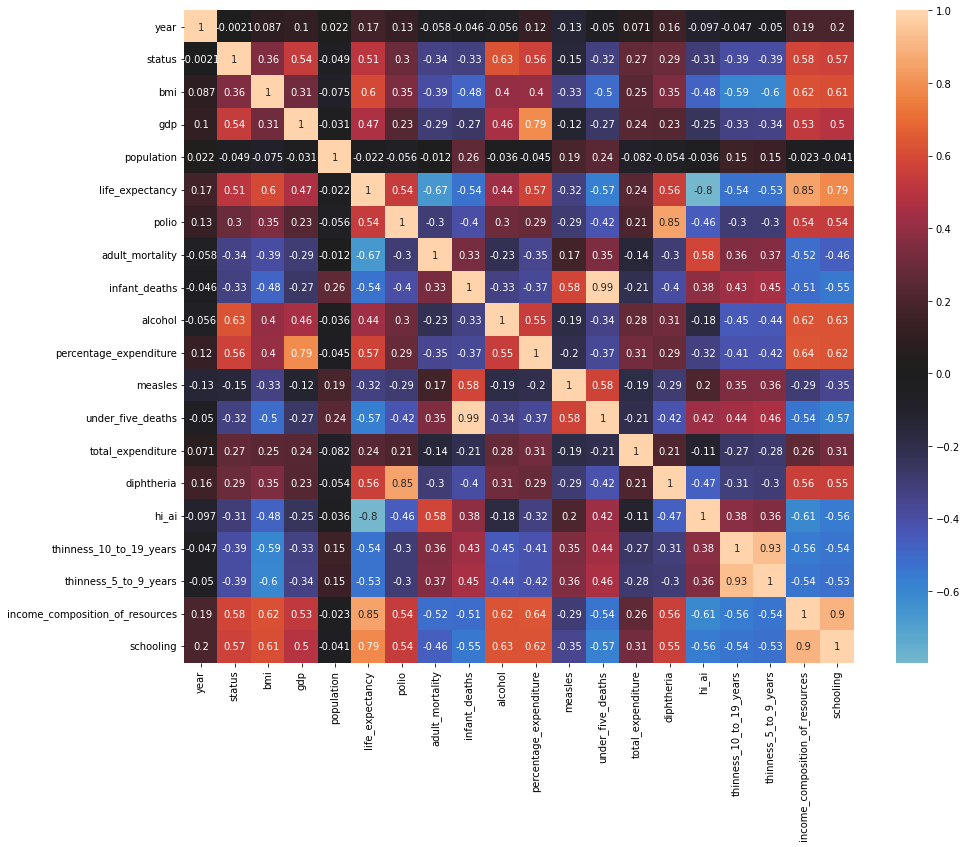

In [628]:
# plot correlation 

plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(),center=0,annot=True)

The plot above shows the correlation between all of the 20 columns in the dataframe. The black spots indicate that there is no correlation, whereas the blue and red indicate a negative and positive correlation, respectively. To cover the means by which this plot should be understood, some of the main points will be highlighted in the following.

It is known, that a positive correlation indicates, that two variables move in the same direction, whereas a negative correlation indicates a decrease in one variable, if an increase happens in another.

Firstly, it is recognized that the columns Year and Population do not correlate with the other columns. Furthermore, there is a strong negative correlation between Life Expectancy and HIV/AIDS, as well as a strong positive correlation between Under Five Deaths and Infant Deaths. 

The Schooling factor is highly correlated with the Life Expectancy, yet the Life Expectancy and the Income Composition of Ressources column are even more correlated. Furthermore, a correlation between the two Thinness columns is present. The GDP and Percentage Expenditure columns are also highly correlated, and the same thing is the case of Diphtheria and Polio. Many interesting aspects can be derived from this correlation matrix. To create the correlation matrix, the heatmap() function from the Seaborne library has been implemented.

To answer the problem statements this far, there haven't been found any significant correlation between the majority of the diseases, and a country's status or GDP. However, it has been found that there is in a general significant correlation between various diseases. These are more often than not positive, meaning that if a country has registered, it is also likely to have registered diphtheria, due to a high correlation between the two. 

Furthermore, it has also been found that there's a strong correlation between life expectancy and income composition of resources (the percentage of the aggregated total of income). This is interesting due to a weaker correlation between life expectancy and GDP, meaning that a country with a higher GDP is not always associated with a higher life expectancy, due to, among other reasons, that the income is not distributed equally.

Furthermore, a pair plot has been used to visualize the Life Expectancy, Alcohol, Measles, Bmi, Polio, Diphtheria and HIV/AIDS columns to determine if there are any relationships between these values. Studying the pair plot, reveals a possible linear relationship between the BMI and Life Expectancy. The same relationship is observed between the Polio and Diphtheria columns. The pair plot function was created using Searborne, specifically the .pairplot function.

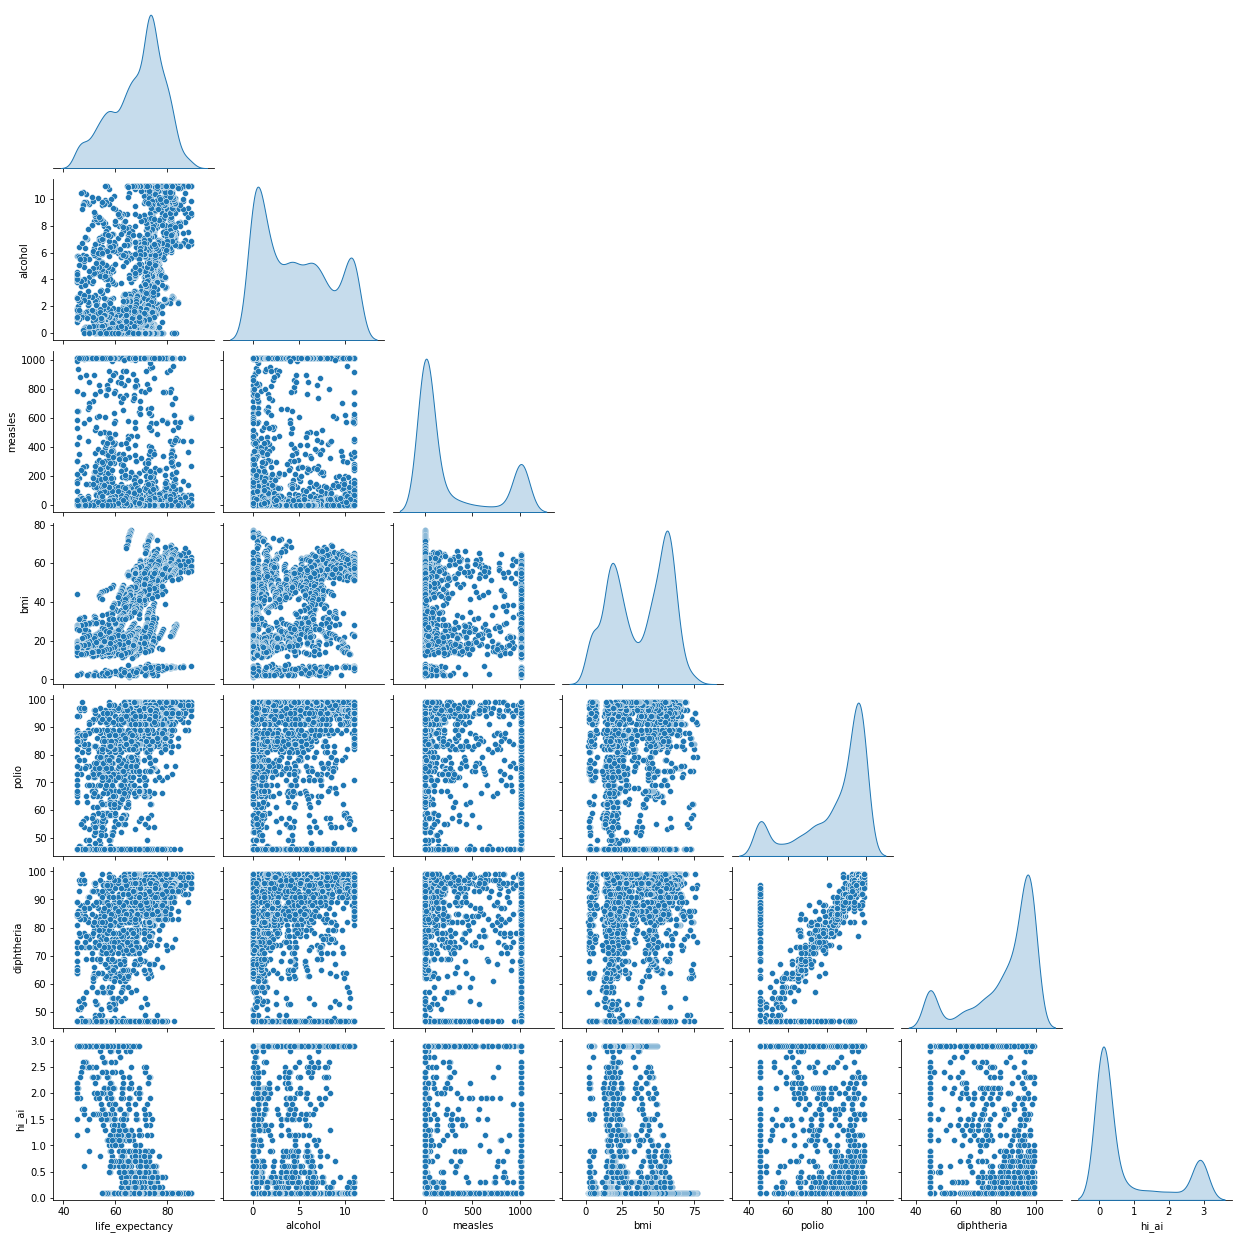

In [629]:
# pairplot between diseases 

diseases_col=df[['life_expectancy','alcohol', 'measles','bmi','polio','diphtheria','hi_ai']]
sns.pairplot(diseases_col,diag_kind='kde', corner=True)

#**4. Unsupervised machine learning (UML)**




Even though we can group countries by their status, there is not much to group the observations by. This is why, using UML, a clustering will be used. However, before clustering a data preparation, including scaling and dimension reduction, will occur.

###4.1 Scaling & dimension reduction

####4.1.1 Scaling

In order to properly use machine learning algorithms, the data needs to be scaled relatively similar and fairly close to a normal distribution. To achieve this, the StandardScaler() method will be applied. As previously shown, extreme values have been filtered using quantiles and IRS (by using the winzorize library). However, this does not account for the differences between values from each column, hereafter referred to as features, since, the population value will be much greater than, for instance, life expectancy. 

(2094, 20)


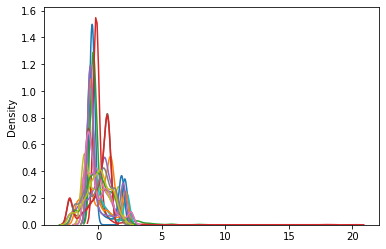

In [630]:
df_scaled = StandardScaler().fit_transform(df_num)
print(df_num.shape)

for i in range(1,20):
  sns.distplot(df_scaled[:,i], hist=False)


As visualized, the data has been scaled, and thus has a mean of 0, and a standard deviation of 1.

#### 4.1.2 Reduction

In order to avoid 'the curse of dimensionality; that being too many dimensions causing a significant decrease in density (of clusters), the UMAP dimensionality reducer is being applied. The reason for choosing the UMAP reducer is due to the algorithms required computation power (which is less than other alternatives such as PCA). Even though the dataset seems fairly small, it is still a factor to be considered when choosing dimensionality reduction methods.

UMAP can be encapsulated into 2 steps; graph construction, and graph projection. The step of graph construction revolves around connecting vertices (points) and creating simplicies (connections), and thus approximate the topology (shape) of the graph. To eliminate issues regarding the radius in specific areas of the graph, UMAP relies on using both fixed and variable radius. Using the simplicies UMAP then computes the densities of the graph using the previously mentioned radiuses, and creates a proxy. The step of graph projection determines the strength of the edges of simplicies, resulting in vertices connected by strong edges (typically found in high dense areas), which are more likely to stay connected in the lower dimensions. Moreover, the strength of the edges is rotational symmetric, leading to the cluster being ‘flipped over’ in some cases after the script has been run. 

In [631]:
reducer = umap.UMAP()
umap_df = reducer.fit_transform(df_scaled)
print(umap_df.shape)


(2094, 2)


After the reduction, the embedding does not fit well with the countries, since there are so many, making the embedding not interoperable;

In [632]:
#commented out due to country labels overlapping in pdf
#sns.scatterplot(umap_df[:,0], umap_df[:,1], hue = df['country'] )

This leads to the usage of the 'status' feature of the dataset, where the embedding proves much more effective;

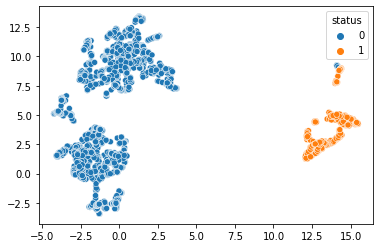

In [633]:
sns.scatterplot(umap_df[:,0], umap_df[:,1], hue = df['status'] )

As shown, the clusters have somewhat high densities, and are clustered well, with only a few 'developing' vertices found in the 'developed' cluster. This can be the case for a number of reasons, one of them being, that the observation has features similiar to observations with 'developed' status, whilst still being classified as 'developing'.

###4.2 Determing amount of clusters

To use the right number of clusters, we use the inertia method. The aim is to get as low inertia as possible, whilst not having too many clusters. With this trade-off principle in mind, it is determined that the number of clusters, k, is determined as the 'elbow' of the graph, since the following amount of clusters after this point, only reduces the inertia by a small amount. Here the KMeans() function from the scikit library is used.

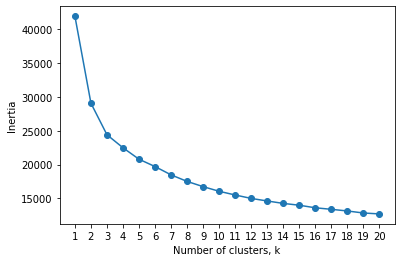

In [634]:
ks = range(1, 21)
inertias = []

for i in ks:
    model = KMeans(n_clusters = i)
    model.fit(df_scaled)
    inertias.append(model.inertia_)

#plot ks vs intertias
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

###4.3 KMeans clustering

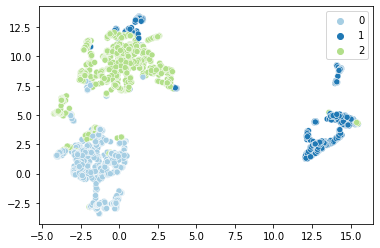

In [635]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_scaled) #only fit since we used umap to transform and reduce the data
sns.scatterplot(umap_df[:,0],umap_df[:,1], hue=kmeans.labels_, palette = 'Paired')

In [636]:
pd.crosstab(kmeans.labels_, df['life_expectancy'])

life_expectancy,45.3,45.4,45.5,45.6,45.7,45.9,46.0,46.2,46.3,46.4,...,83.0,83.2,83.3,83.5,84.0,85.0,86.0,87.0,88.0,89.0
row_0,,,,,,,,,,,,,,,,,,,,,
0,25,1,2,3,3,2,5,2,1,3,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,14,1,1,1,9,9,10,6,9,9
2,0,0,0,0,0,0,0,0,0,1,...,1,0,0,1,2,0,0,0,0,1


The clustering is not really comparable against life expectancy, since there so many different values. We can however compare against a countrys status:

In [637]:
pd.crosstab(kmeans.labels_, df['status'])

status,0,1
row_0,,
0,675,0
1,95,385
2,934,5


By the looks of the crosstabs, countries with developed status seems to be clustered along with each other, whereas countries with developing status, is spread out over 3 clusters, where the majority is spread out over two different clusters, from the developed countries' cluster. The reason for the spread may be the variation in different features, such as gdp, population, different life expectancies etc.

#**5. Supervised Machine Learning**

This part of the project aims to look at the relationship between the individual columns of the dataset, i.e. the different diseases included in the dataset, against the life expectancy. It was briefly touched upon in the data exploration analysis, and will be expanded upon in this part. The aim is to gain a better understanding of which diseases have the biggest impact on the average life expectancy. 

Firstly, the dataset will be preprocessed by first removing both the country and year columns in the dataset, because these are of no interest to the study question. Next, the removal of the population and total expenditure columns will take place, due to the minimum correlations these two shows compared to the rest of the dataset. Afterwards, the dataset is being standardised, so that it can work upon in a machine learning setting. Hereafter the dataset is being split into a train and test set, making the test size equal to the 20% of the whole dataset. When performing the train and test splitting, the Life Expectancy is being used as the target variable, therefore this is going to be the input, and the rest of the dataset is going to be the x input. The problem at hand is a regression problem, because the target variable is Life Expectancy and therefore a continuous variable. 

In [638]:
df.head()


,country,year,status,bmi,gdp,population,life_expectancy,polio,adult_mortality,infant_deaths,...,percentage_expenditure,measles,under_five_deaths,total_expenditure,diphtheria,hi_ai,thinness_10_to_19_years,thinness_5_to_9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,0,19.1,584.259210,33736494.0,65.0,46.0,263.0,60,...,71.279624,1014,82,8.16,65.0,0.1,15.4,15.6,0.479,10.1
1,Afghanistan,2014,0,18.6,612.696514,327582.0,59.9,58.0,271.0,60,...,73.523582,492,82,8.18,62.0,0.1,15.4,15.6,0.476,10.0
2,Afghanistan,2013,0,18.1,631.744976,31731688.0,59.9,62.0,268.0,60,...,73.219243,430,82,8.13,64.0,0.1,15.4,15.6,0.470,9.9
3,Afghanistan,2012,0,17.6,669.959000,3696958.0,59.5,67.0,272.0,60,...,78.184215,1014,82,8.52,67.0,0.1,15.4,15.6,0.463,9.8
4,Afghanistan,2011,0,17.2,63.537231,2978599.0,59.2,68.0,275.0,60,...,7.097109,1014,82,7.87,68.0,0.1,15.4,15.6,0.454,9.5


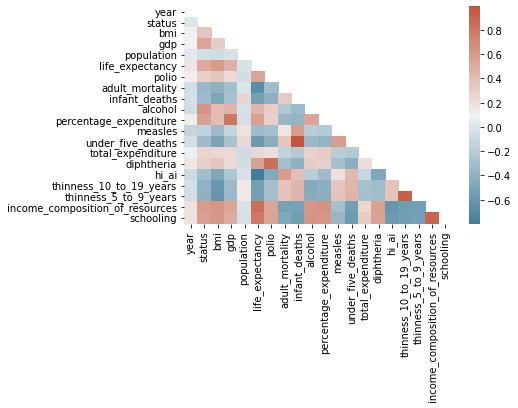

In [639]:
corr = df.corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr, dtype=bool))


sns.heatmap(corr,mask=mask, cmap=cmap)

In [640]:
# dropping the year and country columns

df = df.drop(columns= ["year", "country", "total_expenditure", "population"], axis = True)
df.head()

,status,bmi,gdp,life_expectancy,polio,adult_mortality,infant_deaths,alcohol,percentage_expenditure,measles,under_five_deaths,diphtheria,hi_ai,thinness_10_to_19_years,thinness_5_to_9_years,income_composition_of_resources,schooling
0,0,19.1,584.259210,65.0,46.0,263.0,60,0.01,71.279624,1014,82,65.0,0.1,15.4,15.6,0.479,10.1
1,0,18.6,612.696514,59.9,58.0,271.0,60,0.01,73.523582,492,82,62.0,0.1,15.4,15.6,0.476,10.0
2,0,18.1,631.744976,59.9,62.0,268.0,60,0.01,73.219243,430,82,64.0,0.1,15.4,15.6,0.470,9.9
3,0,17.6,669.959000,59.5,67.0,272.0,60,0.01,78.184215,1014,82,67.0,0.1,15.4,15.6,0.463,9.8
4,0,17.2,63.537231,59.2,68.0,275.0,60,0.01,7.097109,1014,82,68.0,0.1,15.4,15.6,0.454,9.5


In [641]:
# creating a train and test split, making life_expectancy the target variable

X = df.drop(columns = ["life_expectancy"], axis = 1)
y = df["life_expectancy"]

X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

For this project three different regression models are used, each containing its own algorithms. The linear regression model (OLS) is the first one used, followed by running the dataset with the Elastic Net, and finally the Random Forest Model. Each of these models will have its individual scores attached, so it is possible to see how accurate the model has been. For each of the models used there is also a plot attached, where it is possible to see the relationship between the predicted variables and those of the test set, the real-life expectancy. It is clear to see from the plots that the Random Forest Regressor has been best at predicting the outcome, which is also correct given that it has a correct score of 95,5%  attached, compared to the other two models that have 87,6% and 83,7% scored right. 



In [642]:
# loading in the different algorithms and models

model_ols = LinearRegression()
model_el = ElasticNet()
model_rf = RandomForestRegressor(n_estimators=25)

###5.1 Linear Regression model (OLS)

0.8766983990435874


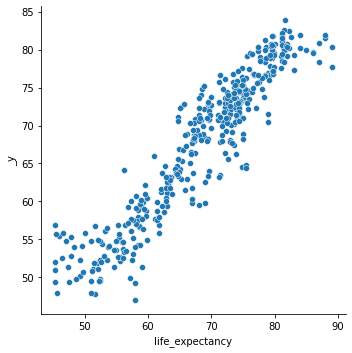

In [643]:
# using the LinearRegression() to fit the data 

model_ols = model_ols.fit(X_train, y_train)
print(model_ols.score(X_test, y_test))
y_pred_ols = model_ols.predict(X_test)
sns.relplot(y_test, y_pred_ols)

lr_score = cross_val_score(model_ols,X_train,y_train,cv=5)


###5.2 Elastic net

0.837826273294811


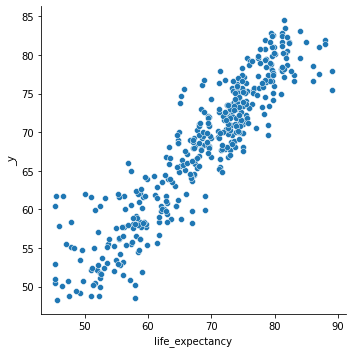

In [644]:
model_el.fit(X_train, y_train)
print(model_el.score(X_test, y_test))
y_pred_el = model_el.predict(X_test)
sns.relplot(y_test, y_pred_el)

el_score = cross_val_score(model_el,X_train,y_train,cv=5)


###5.3 Random Forest Model 

0.9549602296178444


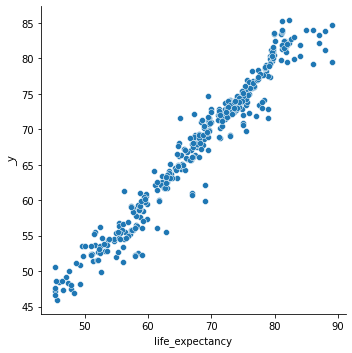

In [645]:
model_rf.fit(X_train, y_train)
print(model_rf.score(X_test, y_test))
y_pred_rf = model_rf.predict(X_test)
sns.relplot(y_test, y_pred_rf)

RFC = RandomForestClassifier()
RFC.fit(X, y.astype(int))
pd.DataFrame({'Variable':X.columns,
              'Importance':RFC.feature_importances_}).sort_values('Importance', ascending=False)

rf_score = cross_val_score(model_rf,X_train,y_train,cv=5)


From the plots derived upstairs are the best performing obviously the Random Forest Regressor model, and therefore we will use this one for the tuning of the following model. In order to be able to tune the model, we will be using the GridSearchCV and the R2 for the scorer. 



In [646]:
# defining the x and y variables again and standardscale them

X = df.drop(columns = ["life_expectancy", "status", "gdp", "adult_mortality", "infant_deaths", "percentage_expenditure", "under_five_deaths", "income_composition_of_resources", "schooling"], axis = 1)
y = df["life_expectancy"]
y = y.astype(int)

df.info()

X_scaled = StandardScaler().fit_transform(X)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2937
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   status                           2094 non-null   int64  
 1   bmi                              2094 non-null   float64
 2   gdp                              2094 non-null   float64
 3   life_expectancy                  2094 non-null   float64
 4   polio                            2094 non-null   float64
 5   adult_mortality                  2094 non-null   float64
 6   infant_deaths                    2094 non-null   int64  
 7   alcohol                          2094 non-null   float64
 8   percentage_expenditure           2094 non-null   float64
 9   measles                          2094 non-null   int64  
 10  under_five_deaths                2094 non-null   int64  
 11  diphtheria                       2094 non-null   float64
 12  hi_ai               

In [647]:
# making the scorer r2

scorer = make_scorer(r2_score)

In [648]:
# defining the parameters for the rf

parameters_rf = {'bootstrap': [True, False],
  'max_depth': [10, 20, None],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [25, 50]}

In [649]:
RFC = RandomForestClassifier()
RFC.fit(X, y)
pd.DataFrame({'Variable':X.columns,
              'Importance':RFC.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
0,bmi,0.187582
2,alcohol,0.155759
7,thinness_5_to_9_years,0.140021
6,thinness_10_to_19_years,0.134996
1,polio,0.108746
4,diphtheria,0.107815
3,measles,0.100650
5,hi_ai,0.064432


In [650]:
# making the grid_obj

grid_obj = GridSearchCV(model_rf, parameters_rf, scoring = scorer)

In [651]:
# fit the model 

grid_fit = grid_obj.fit(X, y)

In [652]:
# getting the best estimater
best_reg = grid_fit.best_estimator_

# fitting the new model again 
best_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=50)

In [653]:
# calculating the best score 

best_reg.score(X_test, y_test)

0.9587530362883445

From the calculations made in the previous text an improvement to the score of the already best performing model, Random Forest Recessor, can be made. The score before were 95,5% correct, whereas the new and improved score is 95,9% correct. 

#**6. Summary/conclusion**

After implementing and running *the data cleaning, preparation, exploratory data analysis, unsupervised and supervised machine learning*, there are some main points to be concluded upon inspecting the dataset. 

One of the main findings in this analysis revolves around the fact that the developed countries have a higher average life expectancy than those from developing countries. This is concluded through a bar plot of the grouped status column against the life expectancy, which shows that developed countries live 10 years longer on average. 

The correlation matrix makes it possible to conclude the relationship between the percentage expenditure on health in each country and the life expectancy. This shows that high expenditure on health will increase the life expectancy at birth. 

Moreover, there is a relationship between under-five deaths, which shows that a higher number of under-five deaths decreases the life expectancy at birth dramatically. The same can be concluded concerning the HIV/AIDS column, which establishes a decrease in the life expectancy. 

Furthermore, it is interesting to observe the positive relationship between both the income composition of resources and the schooling column up against the life expectancy. This means that both of these variables have a positive effect on the average life expectancy. 

Moreover, it is worth noting that it has not been possible to show the correlation of the population with the remaining features/variables of the dataset. 

All of these variables have been trained and tested using several machine learning models to see if there is a model that can most specifically determine the life expectancy. From our three models, we find that the last one, the Random Forest Regressor, is the one able to predict the outcome most correctly. Firstly it scores correct at 95,5 percent of the time, but after tuning it using GridSearchCV, the model ends up being able to predict the right outcome 95,9 percent of the time. 

Furthermore, the countries with status of developed, had a tendency to be grouped together using UML, which indicates that the status of a country could be an indicator of some of the remaining features of the dataset, hereof diseases and wealth.

Thus, we can conclude that factors such as diseases, but also the status of a country can affect the life expectancy.
